# Все функции для получения сигналов и подсчета статистик

In [2]:
def filter_extremums(value_maxes, frame_maxes, value_mines, frame_mines): # Эта функция которая удаляет лишние максимумы и минимумы, после её применения они будут строго чередоваться 
    #                                                                      (один минимум дальше один максимум и так далее. Оканчиваться будет минимумом)
    min_i = 0
    max_i = 0
    result_value = []
    result_frame = []
   
    for i in range(len(value_maxes)):

        

        if min_i == 0:
            min_to_add = [x for x in frame_mines if x < frame_maxes[0]]
            min_i = len(min_to_add)

        else:
            min_to_add = [x for x in frame_mines if x < frame_maxes[max_i]][min_i:]
            min_i += len(min_to_add)
            

        max_to_add = [x for x in frame_maxes if x < frame_mines[min_i]][max_i:]
        
        max_i += len(max_to_add)
        

        min_val = 10000
        max_val = 0

        for element in max_to_add:
            indices = np.where(frame_maxes == element)[0]
            if value_maxes[indices] > max_val:
                max_val = float(value_maxes[indices])
                max_frame = element

       

        for element in min_to_add:
            indices = np.where(frame_mines == element)[0]
            if value_mines[indices] < min_val:
                min_val = float(value_mines[indices])
                min_frame = element

        result_value.extend((min_val, max_val))
        result_frame.extend((min_frame, max_frame))
        

        if max(max_to_add) == frame_maxes[-1]:
            min_to_add = [x for x in frame_mines if x > frame_maxes[-1]]
            result_frame.append(frame_mines[-1])
            result_value.append(value_mines[-1])

            value_maxes = [x for x in  result_value if result_value.index(x)%2!=0]
            frame_maxes = [x for x in  result_frame if result_frame.index(x)%2!=0]

            value_mines = [x for x in  result_value if result_value.index(x)%2==0]
            frame_mines = [x for x in  result_frame if result_frame.index(x)%2==0]

            
            return value_maxes, frame_maxes, value_mines, frame_mines

In [3]:
def cut_signal (start_cut, end_cut, frame, value, mines, maxes): # Функция которая обрезает сигнал
    
   end_cut = len(frame) - end_cut

    # plt.plot(frame, value)
    # plt.show()

   frame_mines = frame[mines]
   frame_maxes = frame[maxes]

   value_mines = value[mines]
   value_maxes = value[maxes]

   closet_number_1 = int(min(frame_mines, key=lambda x: abs(x - start_cut)))
   closet_number_2 = int(min(frame_mines, key=lambda x: abs(x - end_cut)))


   new_frame = np.arange(0, -closet_number_1 + closet_number_2 + 1)
   new_value = value[closet_number_1 : closet_number_2 + 1]

   new_mines = np.array(mines) - closet_number_1
   
   new_mines = new_mines[new_mines <= closet_number_2 - closet_number_1]
   new_mines = new_mines[new_mines >= 0].astype(int)
   
   new_maxes = np.array(maxes) - closet_number_1
   new_maxes = new_maxes[new_maxes <= closet_number_2 - closet_number_1]
   new_maxes = new_maxes[new_maxes >= 0].astype(int)

   value_maxes = new_value[new_maxes]
   frame_maxes = new_frame[new_maxes]

   value_mines = new_value[new_mines]
   frame_mines= new_frame[new_mines]
   
   return value_mines, frame_mines, value_maxes, frame_maxes, new_frame, new_value

In [22]:
def prepare_signal1(path,hand,task,smooth,ordermin,ordermax,fs, graphics): #функция для построения сигналов

    data = json.load(open(path))

    frame, znach = draw_signal (data, task, hand)

    plt.plot(frame, znach)
    plt.show()


    filtered = lowess(znach, frame, is_sorted=True, frac=smooth, it=0)  # 0.02

    frame, value = np.array(filtered[:, 0]), np.array(filtered[:, 1])
    maxTemp = argrelmax(value, order=ordermax)
    minTemp = argrelmin(value, order=ordermin)
    mines = []
    maxes = []

    for maxi in maxTemp[0]:
        if value[maxi] > 0:
            maxes.append(maxi)

    for mini in minTemp[0]:
        if value[mini] > 0:
            mines.append(mini)
  

    value_mines, frame_mines, value_maxes, frame_maxes, new_frame, new_value = cut_signal(200,200, frame, value, mines, maxes)

    
    return new_frame, new_value, value_maxes, frame_maxes, value_mines, frame_mines

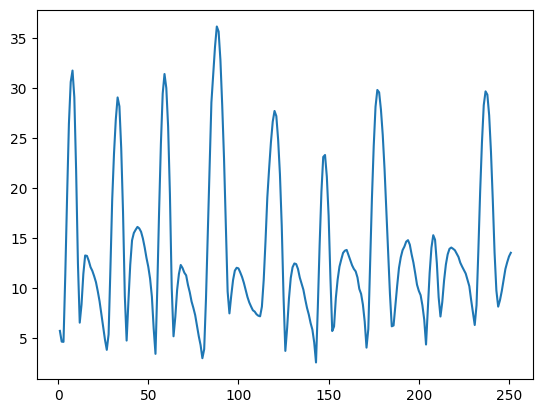

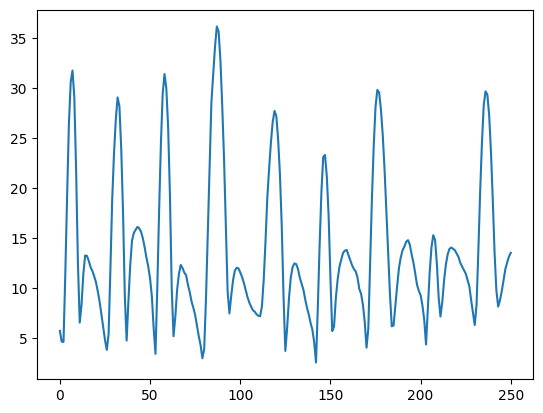

In [33]:
file = 'C:\\Parkinson\\patient\\0_stage\\Patient89\\hand\\leapRecording1_L_m2_patient89.json'
a = prepare_signal1(
    file,
    'left hand',
    1,
    smooth=0.007,
    ordermin=15,
    ordermax=15,
    fs=100,
    graphics=True
)

In [25]:
def draw_signal (data, task, hand): # Функция которая отрисовывает исходные данные
    znach= []
    frame = []
    if task==1:
        for i in range(len(data)):
            if hand in data[i].keys():

                sum_sqr = (float(data[i][hand]['FORE_TIP']['X1']) - float(data[i][hand]['THUMB_TIP']['X1'])) ** 2 \
                + (float(data[i][hand]['FORE_TIP']['Y1']) -float(data[i][hand]['THUMB_TIP']['Y1'])) ** 2 \
                + (float(data[i][hand]['FORE_TIP']['Z1']) -float(data[i][hand]['THUMB_TIP']['Z1'])) ** 2
                distance = math.sqrt(sum_sqr)
                znach.append(distance)
                frame.append(data[i]['frame'])

    if task == 2:
        for i in range(len(data)):
            if hand in data[i].keys():

                sum_sqr = (float(data[i][hand]['MIDDLE_TIP']['X1']) - float(data[i][hand]['CENTRE']['X'])) ** 2 \
                + (float(data[i][hand]['MIDDLE_TIP']['Y1']) -float(data[i][hand]['CENTRE']['Y'])) ** 2 \
                + (float(data[i][hand]['MIDDLE_TIP']['Z1']) -float(data[i][hand]['CENTRE']['Z'])) ** 2
                distance = math.sqrt(sum_sqr)
                znach.append(distance)
                frame.append(data[i]['frame'])

    if task == 3:
        for i in range(len(data)):
            if hand in data[i].keys():

                znach.append(math.sqrt(float(data[i][hand]['LITTLE_DIP']['Z3'])**2\
                                       +float(data[i][hand]['LITTLE_DIP']['X3'])**2\
                                       +float(data[i][hand]['LITTLE_DIP']['Y3'])**2))

                frame.append(data[i]['frame'])


    frame = np.array(frame) - frame[0] # в случае если начало записи пустое и фреймы начинаются не с 0.
    
    return frame, np.array(znach)

In [6]:
def prepare_signal(path,hand,task,smooth,ordermin,ordermax,fs, graphics): #функция для построения сигналов

    data = json.load(open(path))

    frame, znach = draw_signal (data, task, hand)

   
    filtered = lowess(znach, frame, is_sorted=True, frac=smooth, it=0)  # 0.02

    frame, value = np.array(filtered[:, 0]), np.array(filtered[:, 1])
    maxTemp = argrelmax(value, order=ordermax)
    minTemp = argrelmin(value, order=ordermin)
    mines = []
    maxes = []


    for maxi in maxTemp[0]:
        if value[maxi] > 0:
            maxes.append(maxi)

    for mini in minTemp[0]:
        if value[mini] > 0:
            mines.append(mini)
            
    time = frame / fs



    value_mines, frame_mines, value_maxes, frame_maxes, new_frame, new_value = cut_signal(200,200, frame, value, mines, maxes)

    value_maxes, frame_maxes, value_mines, frame_mines =  filter_extremums(value_maxes, frame_maxes, value_mines, frame_mines)

    if graphics:
        
      
        plt.plot(new_frame, new_value, '-')
        plt.plot(frame_maxes, value_maxes, 'ro')
        plt.plot(frame_mines, value_mines, 'bo')
        plt.show()

    return new_frame, new_value, value_maxes, frame_maxes, value_mines, frame_mines

In [8]:
def amplitude_min_max(maxi,mini): # Функция для подсчёта амплитуды
    amp = []
    j = 0
    for i in maxi:
        amp.extend((i - mini[j] , i - mini[j+1]))
        j+=1

    z = [x for x in amp if x > 0.15*max(amp)]
    return np.mean(z), z

In [9]:
def amplitude_median( maxi,mini):  # Функция для подсчёта амплитуды через медиану
    return np.round(np.median(maxi)-np.median(mini),3)

In [10]:
def frequency (fs, frames, z):
                                         # Функция для подсчёта частоты
    time = len(frames)/fs
    return np.round(len(z)/(2*time),3)

In [11]:
def add_to_task (task, stadia, patient, m, hand,  amp_min_max, amp_median , freq, number): #функция добаво
    if len(task) !=0:
        newrow = [number, m,stadia[0],patient + ' ' + m + ' ' + hand, amp_min_max, amp_median , freq]
        task = np.vstack([task, newrow])
    else:
        task = np.array([number, m,stadia[0],patient + ' ' + m + ' ' + hand, amp_min_max, amp_median, freq])
    return task

In [12]:
def patients (stadia, path, graph, f, stats,  task1, task2,task3, problems, inf):
    
    for patient in os.listdir(os.path.join(path,stadia)): #перебираем пациентов
            
            patient_path = os.path.join(path,stadia,patient)+'\\hand' # переходим в папку hand
            for record in (os.listdir(patient_path)): # проходим по каждой записи
                if record.find('json')>0 and  record.find('TR') < 0: # выбираем только json и исключаем записи тремора
                
                    h= re.search('_[A-Z]_',record ).group(0)[1] # Определяем на какую руку было упражнение
                    if h == 'L':
                        hand = 'left hand'
                    else:
                        hand = 'right hand'

                    m = re.search('_[a-z]\d_',record ).group(0)[1:3] 
                    zadacha = re.search('\d_[A-Z]',record ).group(0)[0] # Определяем какое  было упражнение
                    
                    number = re.search('[0-9]+', patient).group(0)
             
                    file = os.path.join(patient_path,record)
                    if inf:
                        print(record,patient, stadia)
                    new_frame, new_value, value_maxes, frame_maxes, value_mines, frame_mines = prepare_signal(file,hand,int(zadacha), \
                                                              smooth=0.007,ordermin=15,
                                                                     ordermax=15, fs = f ,graphics=graph)
                    if len(new_frame)==0:
                        problems.append(record) #если файл пустой, запишем его название 
                        
                    if stats and len(new_frame)>0:
                        amp_min_max, amp = amplitude_min_max (value_maxes,  value_mines)
                        amp_median = amplitude_median (value_maxes, value_mines)
                        freq = frequency (f, new_frame, amp)

                    if zadacha == '1':
                        task1 = add_to_task(task1, stadia, patient, m, hand, float( amp_min_max ),float( amp_median ), float(freq), int(number))
                       
                    if zadacha == '2':
                        task2 = add_to_task(task2, stadia, patient, m, hand, float( amp_min_max ),float( amp_median ), float(freq), int(number))
                        
                    if zadacha == '3':
                        task3 = add_to_task(task3, stadia, patient, m, hand,float( amp_min_max ),float( amp_median ), float(freq), int(number))
    return task1, task2,task3, problems


In [13]:
def signal_processing(path,stats = True, graph=False, fs = 100, inf = True ):
    task1 = []
    task2 = []
    task3 = []
    problems = []
    for stadia in os.listdir(path):
        if stadia == '0_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,  task1, task2, task3, problems, inf)
        if stadia == '1_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,  task1, task2, task3, problems, inf)
        if stadia == '2_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,  task1, task2, task3, problems,inf)
        if stadia == '3_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,   task1, task2, task3, problems,inf)
    return task1, task2, task3, problems

# Обработка сигналов

In [16]:
path = 'C:\\Parkinson\\patient'

leapRecording1_L_m1_patient90.json patient90 0_stage


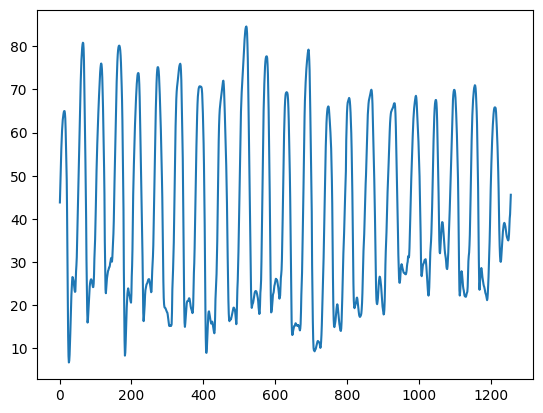

C:\Users\Asus\AppData\Local\Temp\ipykernel_8796\362089505.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_val = float(value_maxes[indices])
C:\Users\Asus\AppData\Local\Temp\ipykernel_8796\362089505.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_val = float(value_mines[indices])


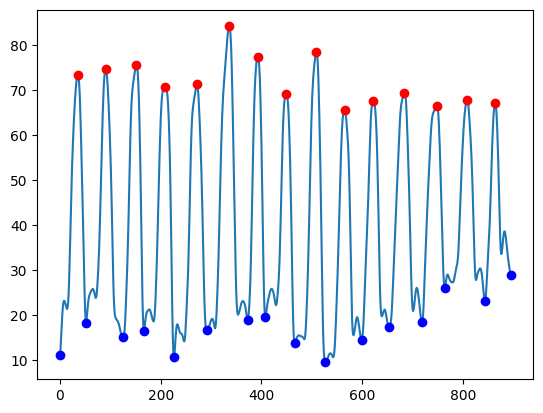

leapRecording1_L_m2_patient90.json patient90 0_stage


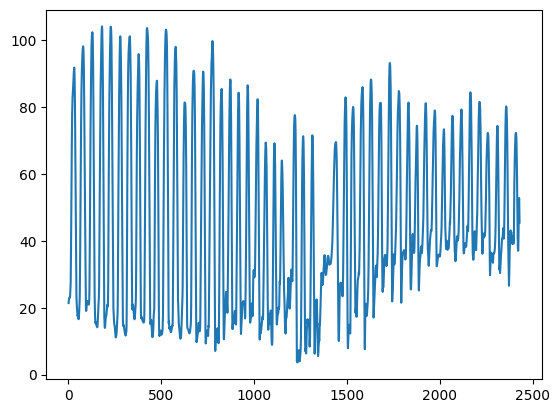

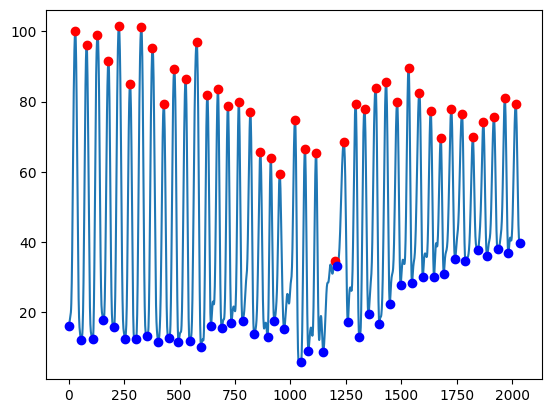

leapRecording1_R_m1_patient90.json patient90 0_stage


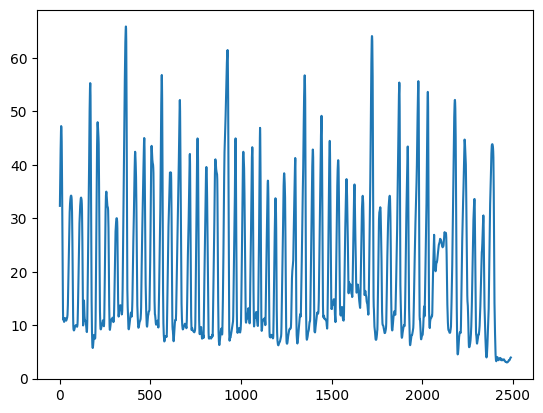

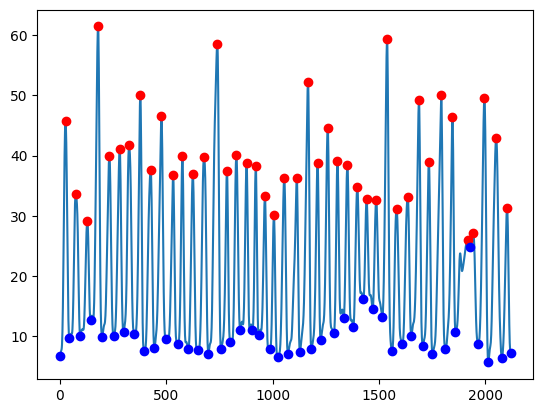

leapRecording1_R_m2_patient90.json patient90 0_stage


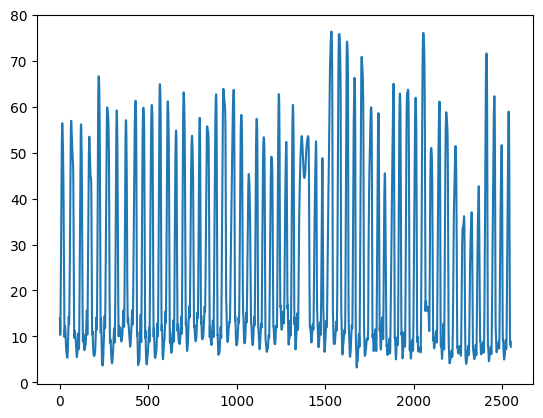

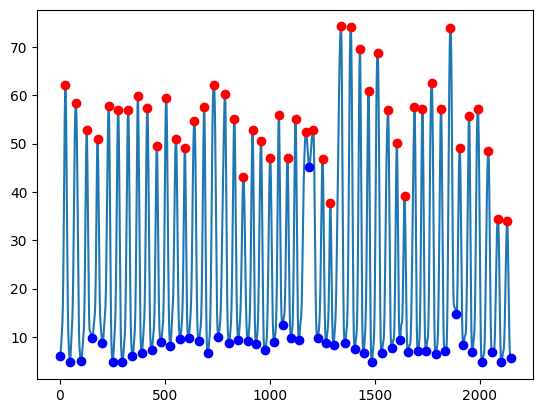

leapRecording2_L_m1_patient90.json patient90 0_stage


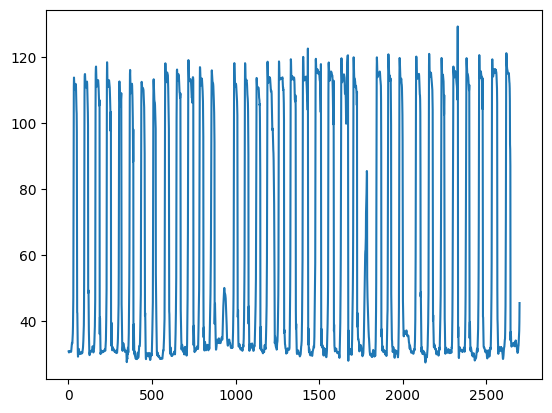

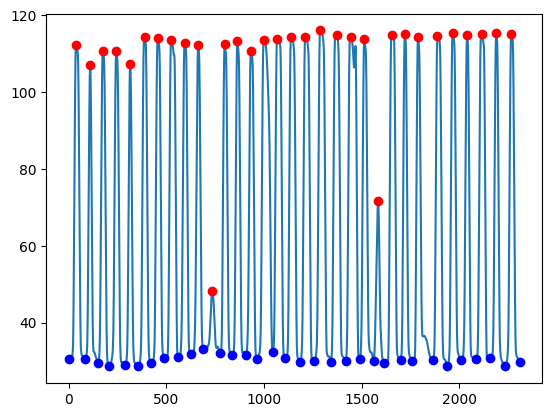

leapRecording2_L_m2_patient90.json patient90 0_stage


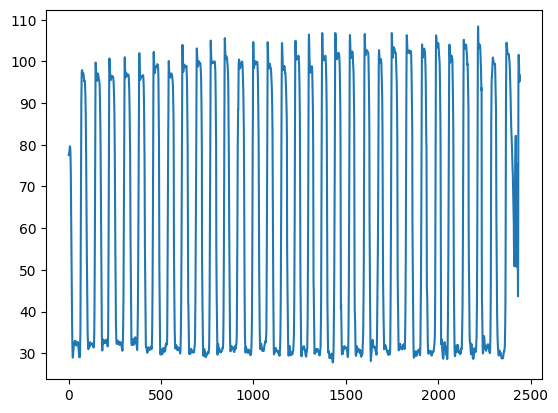

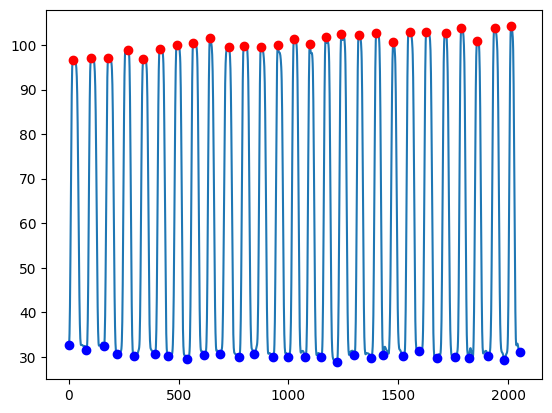

leapRecording2_R_m1_patient90.json patient90 0_stage


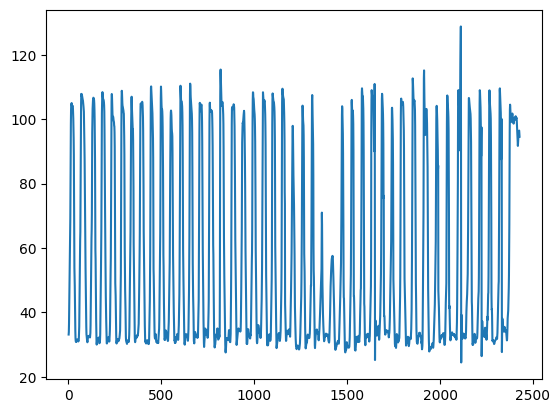

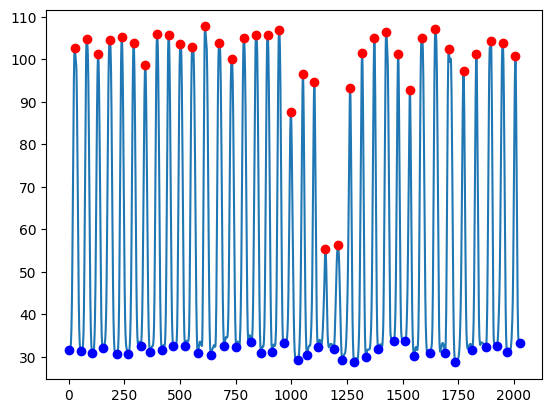

leapRecording2_R_m2_patient90.json patient90 0_stage


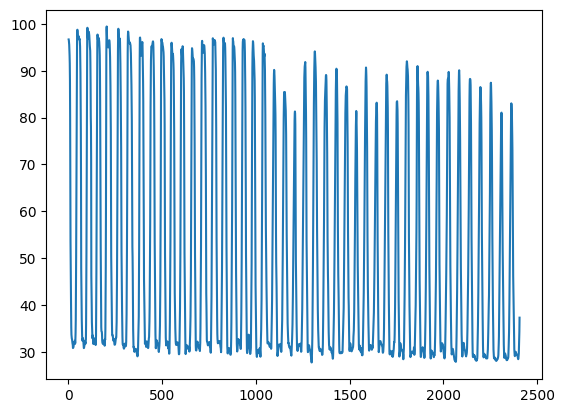

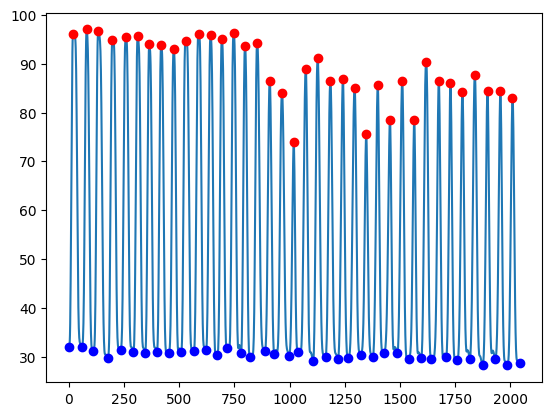

leapRecording3_L_m1_patient90.json patient90 0_stage


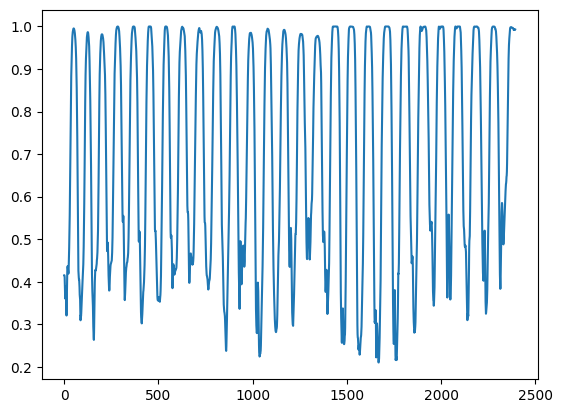

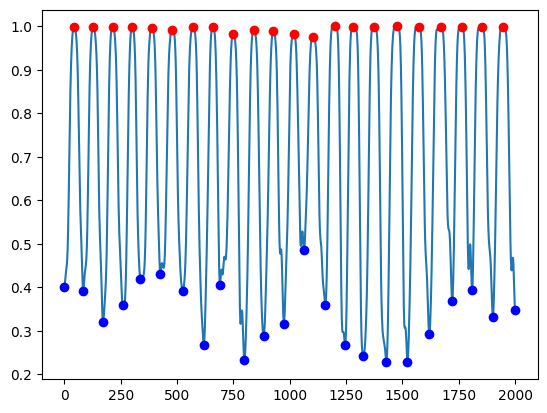

leapRecording3_L_m2_patient90.json patient90 0_stage


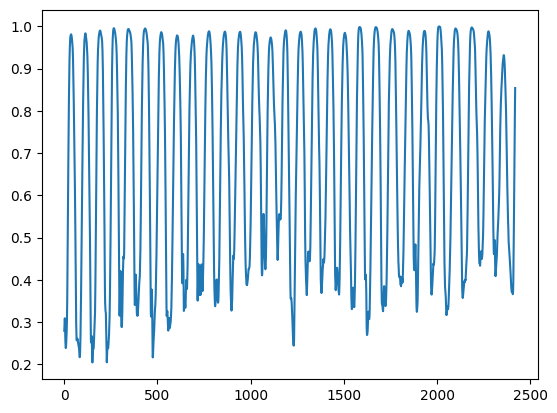

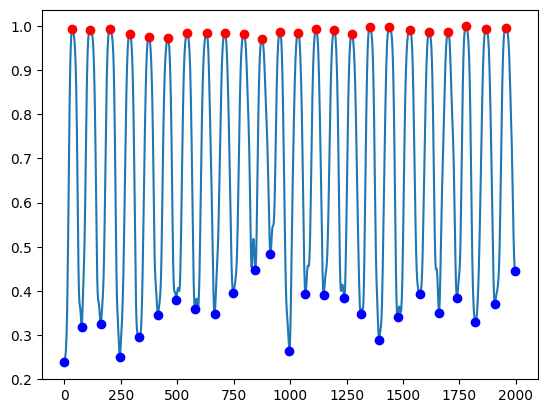

leapRecording3_R_m1_patient90.json patient90 0_stage


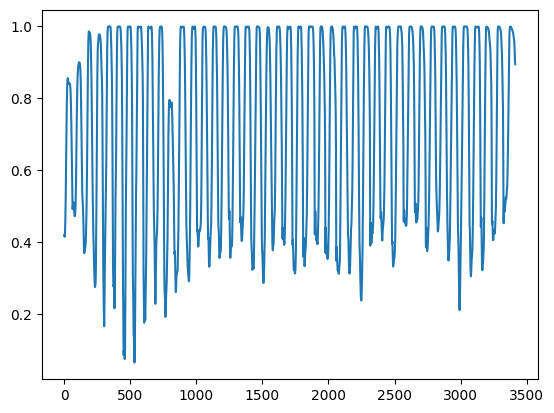

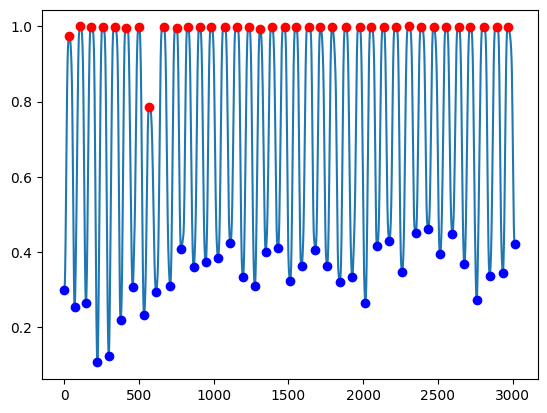

leapRecording3_R_m2_patient90.json patient90 0_stage


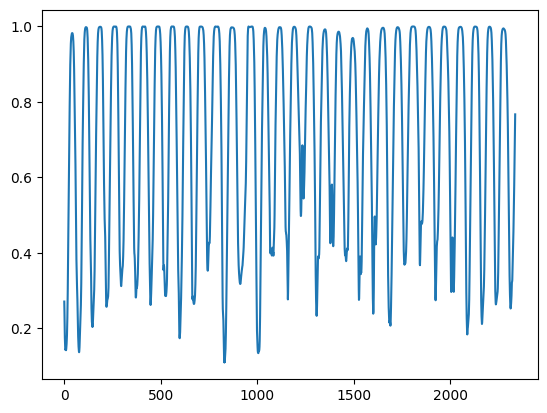

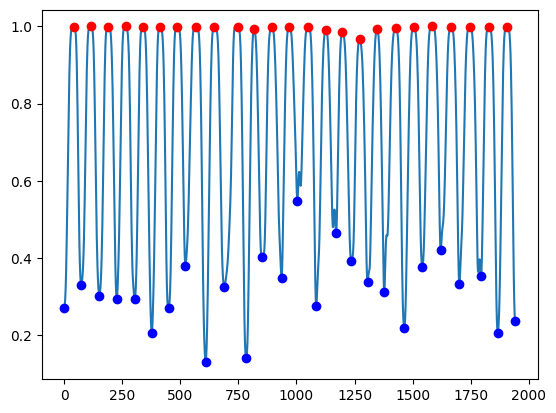

In [34]:
a1,a2,a3,a4 = signal_processing(path, graph = True, inf = True)

In [25]:
df_task1 = pd.DataFrame(a1, columns = ['Индекс пациента', 'Номер эксперимента','Таргет', 'Запись', 'Амплитуда_min_max', 'Амплитуда_median', 'Частота'])
df_task1 = df_task1.astype ({'Частота': float,'Амплитуда_min_max': float, 'Амплитуда_median':float , 'Таргет': int, 'Индекс пациента':int})

df_task2 = pd.DataFrame(a2, columns = ['Индекс пациента',  'Номер эксперимента', 'Таргет','Запись', 'Амплитуда_min_max', 'Амплитуда_median', 'Частота'])
df_task2 = df_task2.astype ({'Частота': float,'Амплитуда_min_max': float, 'Амплитуда_median':float , 'Таргет': int, 'Индекс пациента':int})

df_task3 = pd.DataFrame(a3, columns = ['Индекс пациента',  'Номер эксперимента','Таргет','Запись', 'Амплитуда_min_max', 'Амплитуда_median', 'Частота'])
df_task3 = df_task3.astype ({'Частота': float,'Амплитуда_min_max': float, 'Амплитуда_median':float , 'Таргет': int, 'Индекс пациента':int})


In [26]:
merged_df= pd.merge(df_task1, df_task2,   on=['Запись', 'Таргет', 'Индекс пациента','Номер эксперимента'], how='inner')
merged_df = pd.merge(merged_df, df_task3,   on=['Запись', 'Таргет', 'Индекс пациента','Номер эксперимента'], how='inner')
merged_df = merged_df.rename(columns={'Амплитуда_min_max_x': 'Амп_min_max_1', 'Амплитуда_median_x': 'Амплитуда_median_1', 'Частота_x': 'Частота_1','Амплитуда_min_max_y': 'Амп_min_max_2', 'Амплитуда_median_y': 'Амплитуда_median_2', 'Частота_y': 'Частота_2','Амплитуда_min_max': 'Амп_min_max_3', 'Амплитуда_median': 'Амплитуда_median_3', 'Частота': 'Частота_3'})
merged_df

,Индекс пациента,Номер эксперимента,Таргет,Запись,Амп_min_max_1,Амплитуда_median_1,Частота_1,Амп_min_max_2,Амплитуда_median_2,Частота_2,Амп_min_max_3,Амплитуда_median_3,Частота_3
0,10,m1,0,Patient10 m1 left hand,78.002463,79.073,3.531,67.833390,68.533,1.798,0.630107,0.638,2.022
1,10,m2,0,Patient10 m2 left hand,73.684450,75.061,4.035,64.908213,66.930,2.205,0.666000,0.673,2.197
2,10,m3,0,Patient10 m3 left hand,60.637241,61.987,3.765,67.103081,70.479,2.010,0.669910,0.670,2.276
3,10,m4,0,Patient10 m4 left hand,58.696794,60.421,3.644,47.613902,50.527,2.375,0.658075,0.665,2.279
4,10,m5,0,Patient10 m5 left hand,62.089581,64.734,3.487,52.822951,55.175,2.465,0.675774,0.677,2.402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,80,m2,3,Patient80 m2 right hand,17.183808,11.628,1.904,75.776301,75.835,1.988,0.166198,0.174,4.138
192,82,m1,3,Patient82 m1 left hand,94.171305,97.537,1.414,72.890811,73.546,1.011,0.670788,0.671,0.996
193,82,m2,3,Patient82 m2 left hand,72.873658,72.433,1.135,71.937629,72.081,1.054,0.585955,0.595,1.063
194,82,m1,3,Patient82 m1 right hand,35.453028,32.366,1.735,69.075182,68.513,1.063,0.411753,0.409,1.520


In [40]:
df_zdorov = merged_df[merged_df['Таргет'] == 0]
df_bolen = merged_df[(merged_df['Таргет']== 1) | (merged_df['Таргет']== 2) | (merged_df['Таргет'] == 3)]
df_bolen['Таргет'] = 1
df_1stage = merged_df[merged_df['Таргет']== 1]
df_2stage = merged_df[merged_df['Таргет']== 2]
df_3stage = merged_df[merged_df['Таргет']== 3]


C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\302922943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bolen['Таргет'] = 1


In [41]:
df_zdorov_bolen = pd.concat([df_zdorov,df_bolen])

df_zdorov_1stage = pd.concat([df_zdorov,df_1stage] )

df_23stage = pd.concat([df_3stage,df_2stage])
df_23stage['Таргет'] = 2

df_zdorov_23stage = pd.concat([df_zdorov,df_23stage])

df_1stage_23stage = pd.concat([df_1stage,df_23stage])

In [42]:
dfgr = result.groupby(['Индекс пациента', 'Номер эксперимента', 'Запись']).agg({'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
        'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
       'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})
dfgr.loc[10].loc['m1'].iloc[1]


NameError: name 'result' is not defined

In [43]:

df_test_gr = result.groupby(['Индекс пациента', 'Номер эксперимента']).agg({'Индекс пациента':'max','Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
        'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
       'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})
df_test_gr

NameError: name 'result' is not defined

In [44]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm

In [45]:
def train_test_splitting(df, test_size = 0.2, random_state = 10):

    nums =df['Индекс пациента'].unique()
    df  = df.groupby(['Индекс пациента', 'Номер эксперимента']).agg({'Индекс пациента':'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
        'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
       'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})
    n_test_examples = int(len(df)*test_size)


    seq_test = random.sample(set(nums),len(nums))
    df_test = pd.DataFrame(columns= ['Индекс пациента','Таргет', 
       'Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3'])
    df_train= pd.DataFrame(columns= ['Индекс пациента','Таргет', 
       'Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3'])
    
    q =[]
  
    for i in seq_test:
        new_rows = df.loc[i]
        df_test = pd.concat([df_test,new_rows])
        q.append(i)
        if len(df_test)>n_test_examples:
            break
    numbers = [num for num in nums if num not in q]
    
    seq_train = random.sample(set(numbers), len(numbers))


    n_train_examples = len(df) - len(df_test)
   
    for i in seq_train:
        new_rows = df.loc[i]
        df_train = pd.concat([df_train,new_rows])
        if len(df_train)>n_train_examples:
        
            break
    print('Распределение элементов в тест выборке \nКласс 0: ', len(df_test[df_test['Таргет']== 0 ]),'\nКласс1: ', len(df_test) - len(df_test[df_test['Таргет']== 0 ]))

    print('Распределение элементов в train выборке \nКласс0: ', len(df_train[df_train['Таргет']== 0 ]),'\nКласс1: ', len(df_train) - len(df_train[df_train['Таргет']== 0 ]))

    return np.array(df_train[['Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3']]), np.array(df_test[['Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3']]), np.array(df_train['Таргет']).astype(int), np.array(df_test['Таргет']).astype(int)


# Больные/здоровые

In [93]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_zdorov_bolen)

Распределение элементов в тест выборке 
Класс 0:  11 
Класс1:  11
Распределение элементов в train выборке 
Класс0:  24 
Класс1:  48


C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[ 7  4]
 [ 1 10]]
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.71      0.91      0.80        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22

Точность 0.7727272727272727


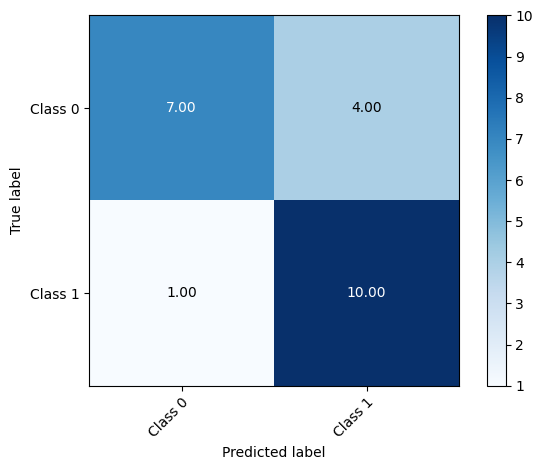

In [94]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)

[[9 2]
 [2 9]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.82      0.82      0.82        11

    accuracy                           0.82        22
   macro avg       0.82      0.82      0.82        22
weighted avg       0.82      0.82      0.82        22

Точность 0.8181818181818182


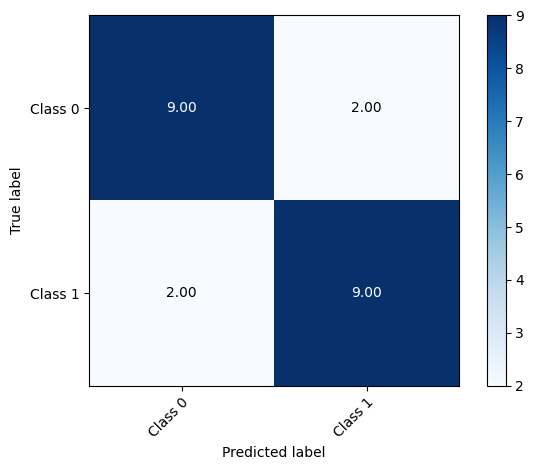

In [95]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

# Здоровые/1 Стадия

In [89]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_zdorov_1stage)


Распределение элементов в тест выборке 
Класс 0:  5 
Класс1:  5
Распределение элементов в train выборке 
Класс0:  30 
Класс1:  9


C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[5 0]
 [3 2]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

Точность 0.7


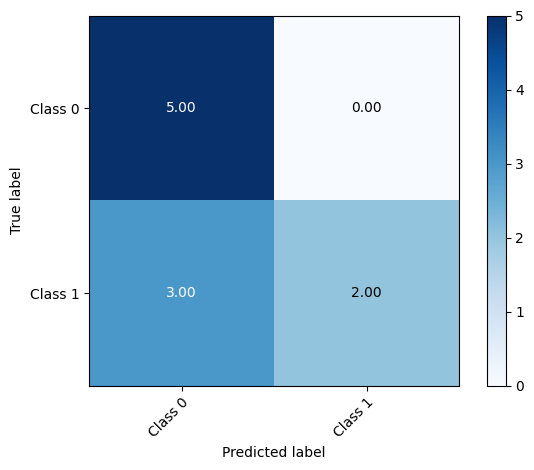

In [90]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)

[[5 0]
 [3 2]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

Точность 0.7


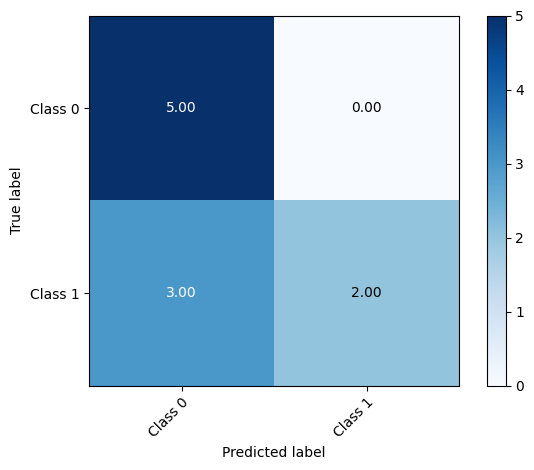

In [92]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

# Здоров/ 23СТадия

In [97]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_zdorov_23stage)

Распределение элементов в тест выборке 
Класс 0:  9 
Класс1:  8
Распределение элементов в train выборке 
Класс0:  26 
Класс1:  37


C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[9 0]
 [2 6]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           2       1.00      0.75      0.86         8

    accuracy                           0.88        17
   macro avg       0.91      0.88      0.88        17
weighted avg       0.90      0.88      0.88        17

Точность 0.8823529411764706





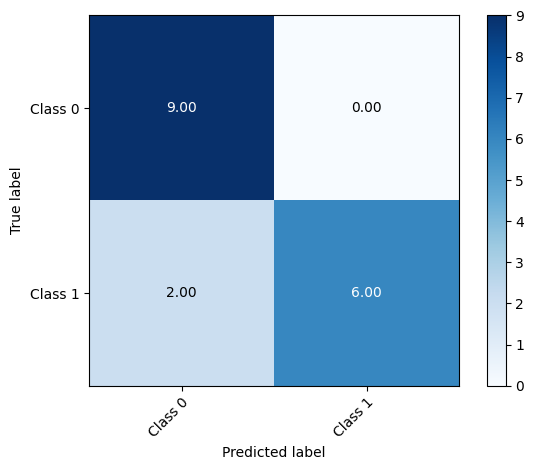

In [98]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)
print('\n\n')


[[9 0]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

Точность 1.0


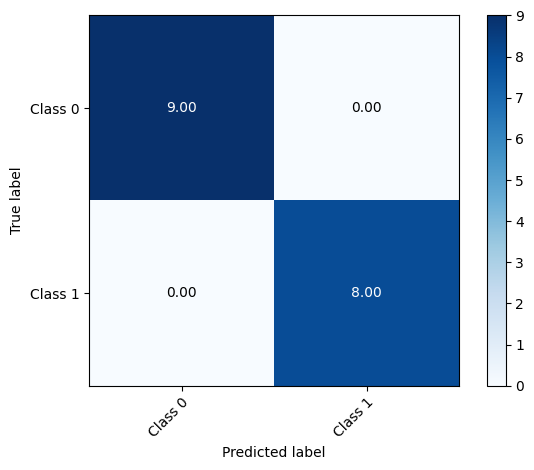

In [63]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

# 1Стадия/23 СТадия

In [99]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_1stage_23stage)

Распределение элементов в тест выборке 
Класс 0:  0 
Класс1:  12
Распределение элементов в train выборке 
Класс0:  0 
Класс1:  47


C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[0 6]
 [0 8]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.57      1.00      0.73         8

    accuracy                           0.57        14
   macro avg       0.29      0.50      0.36        14
weighted avg       0.33      0.57      0.42        14

Точность 0.5714285714285714


c:\Users\Asus\anaconda3\envs\polguev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\anaconda3\envs\polguev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\anaconda3\envs\polguev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


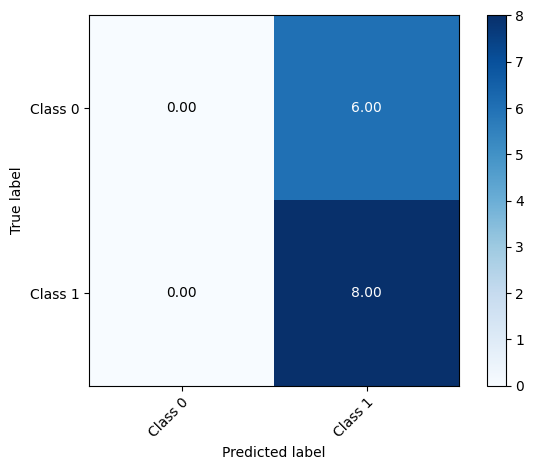

In [140]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)

[[1 5]
 [4 4]]
              precision    recall  f1-score   support

           1       0.20      0.17      0.18         6
           2       0.44      0.50      0.47         8

    accuracy                           0.36        14
   macro avg       0.32      0.33      0.33        14
weighted avg       0.34      0.36      0.35        14

Точность 0.35714285714285715


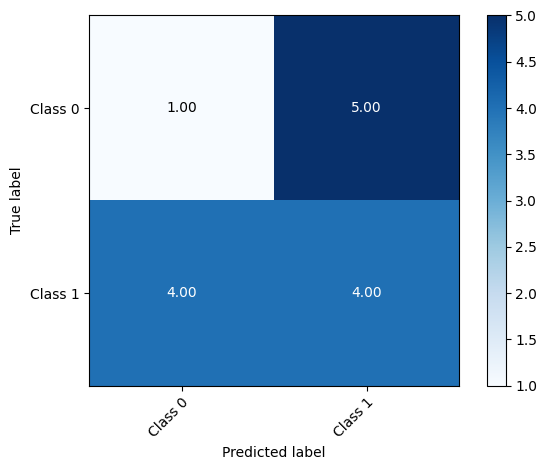

In [141]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

# Гистограммы 

Задание 1


<Axes: title={'center': '1 Стадия'}, ylabel='Count'>

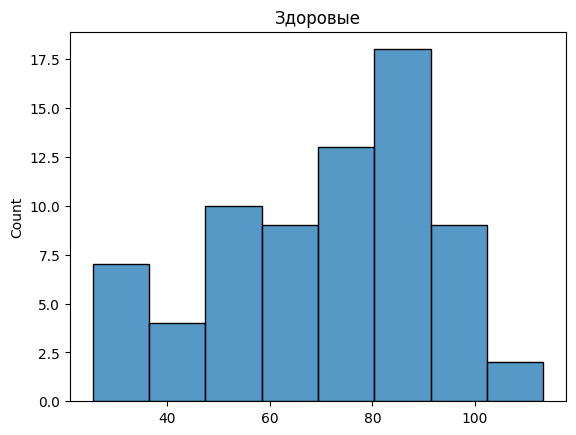

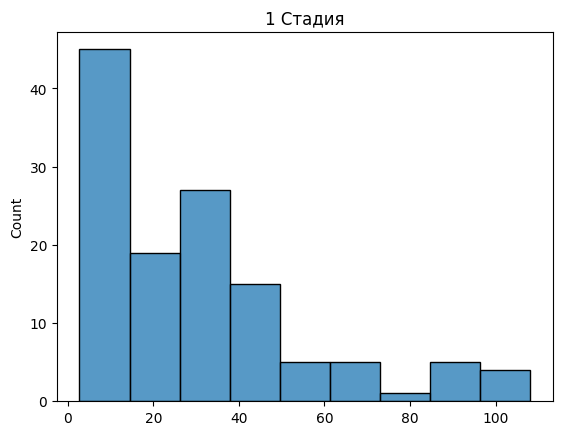

In [ ]:
print('Задание 1')
plt.figure()
plt.title('Здоровые')
sns.histplot(df_stage0_task1['Амплитуда_median'].values)
plt.figure()
plt.title('1 Стадия')
sns.histplot(df_bolen_task1['Амплитуда_median'].values)

Задание 1


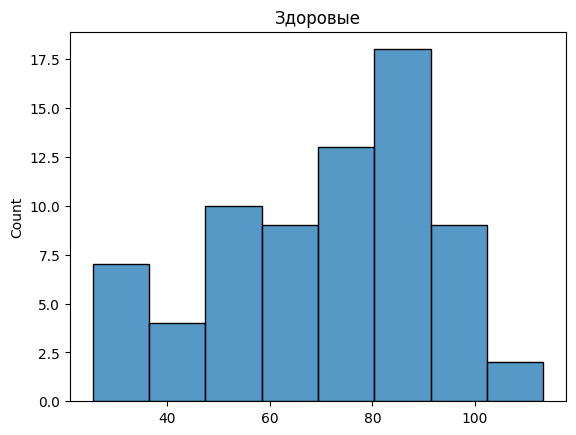

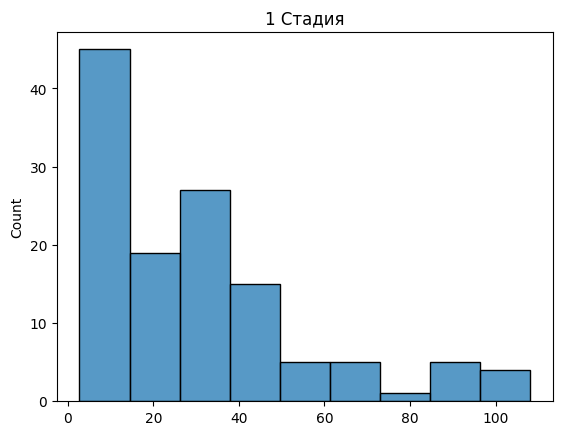

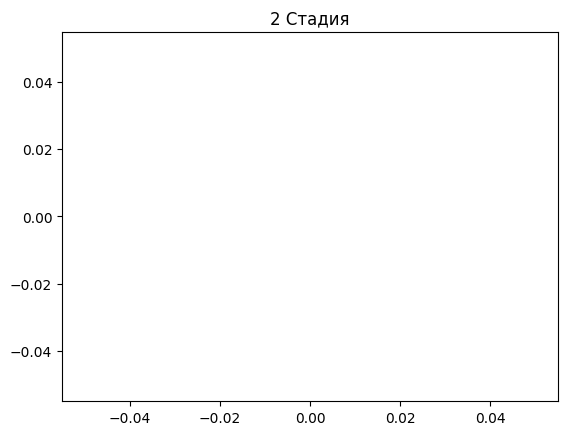

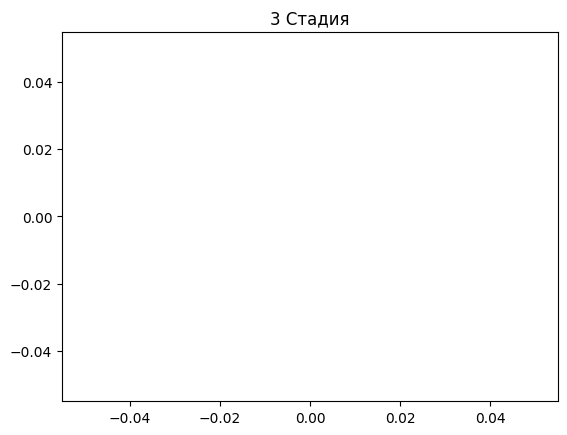

In [ ]:
print('Задание 1')
plt.figure()
plt.title('Здоровые')
sns.histplot(df_stage0_task1['Амплитуда_median'].values)
plt.figure()
plt.title('1 Стадия')
sns.histplot(df_stage1_task1['Амплитуда_median'].values)
plt.figure()
plt.title('2 Стадия')
sns.histplot(df_stage2_task1['Амплитуда_median'].values)
plt.figure()
plt.title('3 Стадия')
sns.histplot(df_stage3_task1['Амплитуда_median'].values)
plt.show()

Задание 2


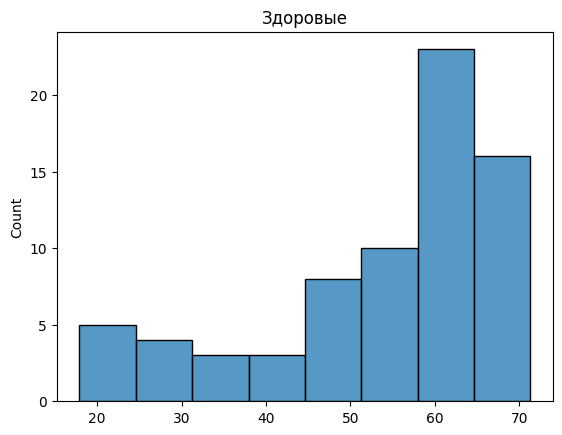

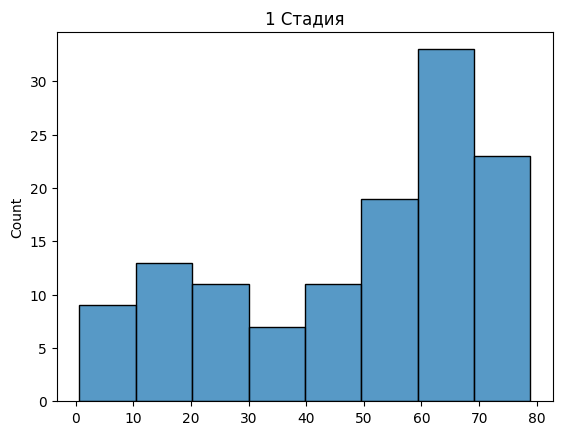

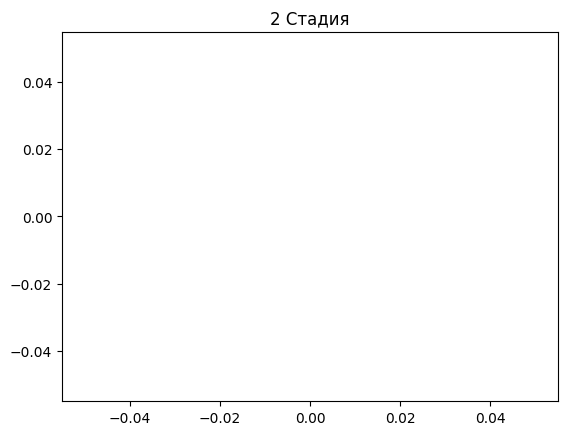

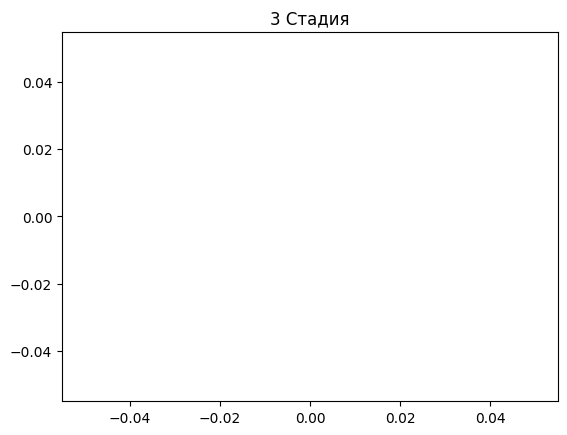

In [ ]:
print('Задание 2')
plt.figure()
plt.title('Здоровые')
sns.histplot(df_stage0_task2['Амплитуда_median'].values)
plt.figure()
plt.title('1 Стадия')
sns.histplot(df_stage1_task2['Амплитуда_median'].values)
plt.figure()
plt.title('2 Стадия')
sns.histplot(df_stage2_task2['Амплитуда_median'].values)
plt.figure()
plt.title('3 Стадия')
sns.histplot(df_stage3_task2['Амплитуда_median'].values)
plt.show()

Задание 3


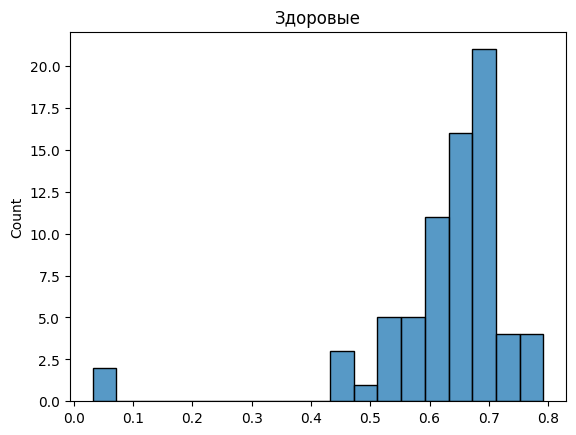

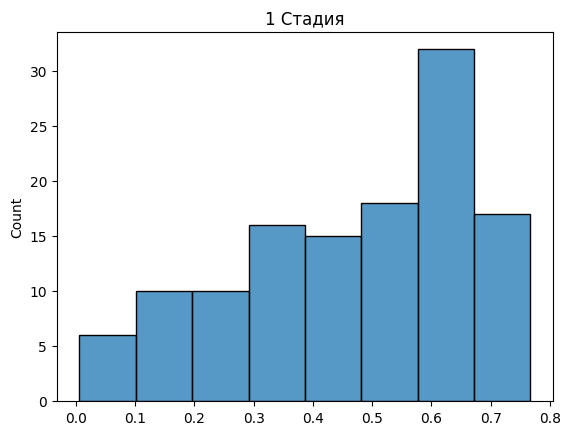

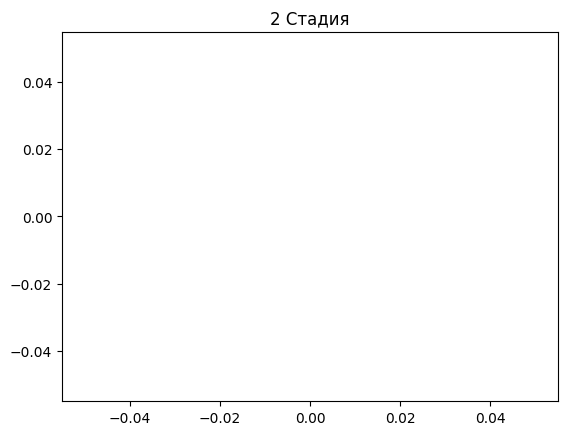

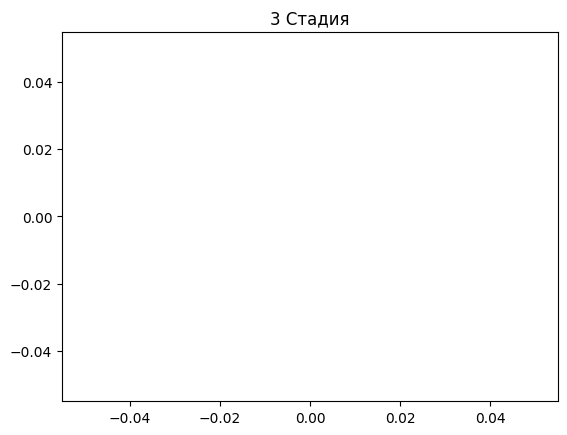

In [ ]:
print('Задание 3')
plt.figure()
plt.title('Здоровые')
sns.histplot(df_stage0_task3['Амплитуда_median'].values)
plt.figure()
plt.title('1 Стадия')
sns.histplot(df_stage1_task3['Амплитуда_median'].values)
plt.figure()
plt.title('2 Стадия')
sns.histplot(df_stage2_task3['Амплитуда_median'].values)
plt.figure()
plt.title('3 Стадия')
sns.histplot(df_stage3_task3['Амплитуда_median'].values)
plt.show()

In [ ]:
p_value = 0.1

In [ ]:
print('Task1')
for a in df_task1['Таргет'].unique():
    for b in df_task1['Таргет'].unique():
        if a!=b:
            buff1 = df_task1[df_task1['Таргет']== a]
            buff2 = df_task1[df_task1['Таргет']== b]
            _, amp = stats.ttest_ind(buff1['Амплитуда_min_max'].values, buff2['Амплитуда_min_max'].values, equal_var=False)
            _, amp1 = stats.ttest_ind(buff1['Амплитуда_median'].values, buff2['Амплитуда_median'].values, equal_var=False)
            _, freq = stats.ttest_ind(buff1['Частота'].values, buff2['Частота'].values, equal_var=False)
            print(f'Стадия {a} и стадия {b} по амплитуде_min_max' , amp, 'Выборки различимы' if amp<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по амплитуде_median' , amp1, 'Выборки различимы' if amp1<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по частоте' , freq, 'Выборки различимы' if freq<=p_value else 'Выборки неразличимы \n')

Task1
Стадия 0 и стадия 1 по амплитуде_min_max 6.73283229714698e-26 Выборки различимы
Стадия 0 и стадия 1 по амплитуде_median 9.060632870797318e-24 Выборки различимы
Стадия 0 и стадия 1 по частоте 0.08930568742378371 Выборки различимы
Стадия 1 и стадия 0 по амплитуде_min_max 6.73283229714698e-26 Выборки различимы
Стадия 1 и стадия 0 по амплитуде_median 9.060632870797318e-24 Выборки различимы
Стадия 1 и стадия 0 по частоте 0.08930568742378371 Выборки различимы


In [ ]:
print('Task2')
for a in df_task2['Таргет'].unique():
    for b in df_task2['Таргет'].unique():
        if a!=b:
            buff1 = df_task2[df_task2['Таргет']== a]
            buff2 = df_task2[df_task2['Таргет']== b]
            _, amp = stats.ttest_ind(buff1['Амплитуда_min_max'].values, buff2['Амплитуда_min_max'].values, equal_var=False)
            _, amp1 = stats.ttest_ind(buff1['Амплитуда_median'].values, buff2['Амплитуда_median'].values, equal_var=False)
            _, freq = stats.ttest_ind(buff1['Частота'].values, buff2['Частота'].values, equal_var=False)
            print(f'Стадия {a} и стадия {b} по амплитуде_min_max' , amp, 'Выборки различимы' if amp<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по амплитуде_median' , amp1, 'Выборки различимы' if amp1<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по частоте' , freq, 'Выборки различимы' if freq<=p_value else 'Выборки неразличимы \n')

Task2
Стадия 0 и стадия 1 по амплитуде_min_max 0.2915004827537589 Выборки неразличимы
Стадия 0 и стадия 1 по амплитуде_median 0.04805032495428437 Выборки различимы
Стадия 0 и стадия 1 по частоте 0.212254545273472 Выборки неразличимы 

Стадия 1 и стадия 0 по амплитуде_min_max 0.2915004827537589 Выборки неразличимы
Стадия 1 и стадия 0 по амплитуде_median 0.04805032495428437 Выборки различимы
Стадия 1 и стадия 0 по частоте 0.212254545273472 Выборки неразличимы 



In [ ]:
print('Task3')
for a in df_task3['Таргет'].unique():
    for b in df_task3['Таргет'].unique():
        if a!=b:
            buff1 = df_task3[df_task3['Таргет']== a]
            buff2 = df_task3[df_task3['Таргет']== b]
            _, amp = stats.ttest_ind(buff1['Амплитуда_min_max'].values, buff2['Амплитуда_min_max'].values, equal_var=False)
            _, amp1 = stats.ttest_ind(buff1['Амплитуда_median'].values, buff2['Амплитуда_median'].values, equal_var=False)
            _, freq = stats.ttest_ind(buff1['Частота'].values, buff2['Частота'].values, equal_var=False)
            print(f'Стадия {a} и стадия {b} по амплитуде_min_max' , amp, 'Выборки различимы' if amp<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по амплитуде_median' , amp1, 'Выборки различимы' if amp1<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по частоте' , freq, 'Выборки различимы' if freq<=p_value else 'Выборки неразличимы \n')

Task3
Стадия 0 и стадия 1 по амплитуде_min_max 5.810504903182284e-07 Выборки различимы
Стадия 0 и стадия 1 по амплитуде_median 1.2281653299675854e-10 Выборки различимы
Стадия 0 и стадия 1 по частоте 0.06381870887277223 Выборки различимы
Стадия 1 и стадия 0 по амплитуде_min_max 5.810504903182284e-07 Выборки различимы
Стадия 1 и стадия 0 по амплитуде_median 1.2281653299675854e-10 Выборки различимы
Стадия 1 и стадия 0 по частоте 0.06381870887277223 Выборки различимы
